In [7]:
!pip install --upgrade sklearn

Requirement already up-to-date: sklearn in /opt/conda/envs/Python36/lib/python3.6/site-packages (0.0)


# Data Science Capstone Week 1

In [8]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, metrics, svm
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


# Capstone Week 2

Loading data

In [10]:
# The code was removed by Watson Studio for sharing.

/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (33) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


## Drop features that have no impact on outcome, such as arbitrary report numbers, etc.

In [11]:
df.drop(['OBJECTID', 'INCKEY', 'INTKEY', 'COLDETKEY', 'REPORTNO', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'INCDATE', 'SEVERITYCODE.1', 'SEVERITYDESC', 'ST_COLCODE', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY', 'X','Y', 'SDOT_COLCODE', 'SDOT_COLDESC', 'SDOTCOLNUM'], 1, inplace = True)

## Check datatypes of imported data

In [12]:
df.dtypes

SEVERITYCODE       int64
STATUS            object
ADDRTYPE          object
LOCATION          object
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
INCDTTM           object
JUNCTIONTYPE      object
INATTENTIONIND    object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT     object
SPEEDING          object
HITPARKEDCAR      object
dtype: object

## Preprocessing - Review each feature and fill in the NA's.

In [13]:
df['SPEEDING'].fillna('N', inplace =True)
df['INATTENTIONIND'].fillna('N', inplace =True)
df['ROADCOND'].fillna('Unknown', inplace = True)
df['LIGHTCOND'].fillna('Unknown', inplace = True)
df['WEATHER'].fillna('Other', inplace = True)
df['UNDERINFL'].replace({'N':'0', 'Y':'1'}, inplace = True)
df['COLLISIONTYPE'].fillna('Other', inplace = True)

## Filling in the remaining NA's with '-99999' to make them extreme outliers

In [14]:
df.fillna(-99999, inplace = True)

## Checking how many more features have NA's

In [15]:
df.isnull().sum(axis = 0)

SEVERITYCODE      0
STATUS            0
ADDRTYPE          0
LOCATION          0
COLLISIONTYPE     0
PERSONCOUNT       0
PEDCOUNT          0
PEDCYLCOUNT       0
VEHCOUNT          0
INCDTTM           0
JUNCTIONTYPE      0
INATTENTIONIND    0
UNDERINFL         0
WEATHER           0
ROADCOND          0
LIGHTCOND         0
PEDROWNOTGRNT     0
SPEEDING          0
HITPARKEDCAR      0
dtype: int64

## Handling the non-numerical data

In [16]:
def handle_non_numerical_data(df):
    columns = df.columns.values
    
    for column in columns:
        text_digit_vals = {}
        def convert_to_int(val):
            return text_digit_vals[val]
        
        if df[column].dtype != np.int64 and df[column].dtype != np.float64:
            column_contents = df[column].values.tolist()
            unique_elements = set(column_contents)
            x = 0
            for unique in unique_elements:
                if unique not in text_digit_vals:
                    text_digit_vals[unique] = x
                    x += 1
            df[column] = list(map(convert_to_int, df[column]))
    return df
df = handle_non_numerical_data(df)
df.head

<bound method NDFrame.head of         SEVERITYCODE  STATUS  ADDRTYPE  LOCATION  COLLISIONTYPE  PERSONCOUNT  \
0                  2       0         3      3362              5            2   
1                  1       0         1      2960              2            2   
2                  1       0         1      8705              4            4   
3                  1       0         1      4570              8            3   
4                  2       0         3     15850              5            2   
5                  1       0         3     19391              5            2   
6                  1       0         3     23222              5            2   
7                  2       0         3     16031              1            3   
8                  1       0         1     23464              4            2   
9                  2       0         3      8473              5            2   
10                 1       0         2      5657              8            2   
11        

In [17]:
df['SEVERITYCODE'].value_counts() #Even though the metadata description shows 5 codes to classify severity, how many are actually present in the data?

1    136485
2     58188
Name: SEVERITYCODE, dtype: int64

## Setting up the Decision Tree Classifier

In [18]:
X = df.drop(['SEVERITYCODE'],1).values
y = df['SEVERITYCODE'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 4)
X = preprocessing.StandardScaler()

In [19]:
X_train.shape

(136271, 18)

In [20]:
y_train.shape

(136271,)

In [21]:
clf = DecisionTreeClassifier(criterion = "entropy")
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy')

In [22]:
prediction = clf.predict(X_test)

In [23]:
print("DecisionTrees's Accuracy: ", metrics.accuracy_score(y_test, prediction))

DecisionTrees's Accuracy:  0.6855244683401254


[Text(284.19286608705136, 216.43333333333334, 'X[5] <= 0.5\nentropy = 0.881\nsamples = 136271\nvalue = [95402, 40869]'),
 Text(235.9385817642267, 214.42, 'X[6] <= 0.5\nentropy = 0.852\nsamples = 131415\nvalue = [94913, 36502]'),
 Text(150.73906465267515, 212.40666666666667, 'X[4] <= 2.5\nentropy = 0.827\nsamples = 127659\nvalue = [94448, 33211]'),
 Text(84.0960485553626, 210.39333333333335, 'X[3] <= 4.5\nentropy = 0.713\nsamples = 85860\nvalue = [69072, 16788]'),
 Text(40.26683614452997, 208.38, 'X[3] <= 3.5\nentropy = 0.549\nsamples = 49445\nvalue = [43166, 6279]'),
 Text(18.44690663173671, 206.36666666666667, 'X[3] <= 2.5\nentropy = 0.813\nsamples = 21869\nvalue = [16374, 5495]'),
 Text(4.587396413534722, 204.35333333333332, 'X[13] <= 1.0\nentropy = 0.507\nsamples = 9441\nvalue = [8379, 1062]'),
 Text(0.2822702465372006, 202.34, 'X[14] <= 6.5\nentropy = 0.264\nsamples = 513\nvalue = [490, 23]'),
 Text(0.26136133938629685, 200.32666666666665, 'X[2] <= 21844.0\nentropy = 0.256\nsamples

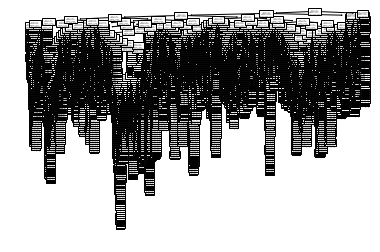

In [24]:
tree.plot_tree(clf)

## Let's compare to K-Nearest Neighbors performance

KNearestNeighbor's Accuracy with k= 1 :  0.5829766103900551
KNearestNeighbor's Accuracy with k= 2 :  0.667682613609123
KNearestNeighbor's Accuracy with k= 3 :  0.6172220129447622
KNearestNeighbor's Accuracy with k= 4 :  0.6724256018629499
KNearestNeighbor's Accuracy with k= 5 :  0.6404232731755761
KNearestNeighbor's Accuracy with k= 6 :  0.6775795349474333
KNearestNeighbor's Accuracy with k= 7 :  0.6550118146638814
KNearestNeighbor's Accuracy with k= 8 :  0.6822882777987055
KNearestNeighbor's Accuracy with k= 9 :  0.6665525153248176
KNearestNeighbor's Accuracy with k= 10 :  0.6847539467826445
KNearestNeighbor's Accuracy with k= 11 :  0.6732132461217082
KNearestNeighbor's Accuracy with k= 12 :  0.6886407999726036
KNearestNeighbor's Accuracy with k= 13 :  0.6789322283483442
KNearestNeighbor's Accuracy with k= 14 :  0.6910208554501558
KNearestNeighbor's Accuracy with k= 15 :  0.6843430019519879
KNearestNeighbor's Accuracy with k= 16 :  0.6937262422519777
KNearestNeighbor's Accuracy with k

Text(0, 0.5, 'Accuracy')

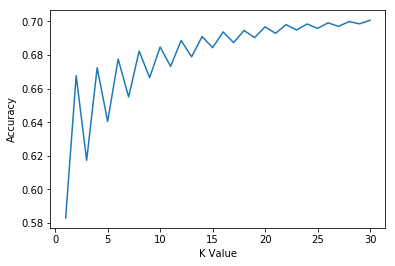

In [45]:
rangeofk = range(1, 31)
accuracy_score = []
for k in rangeofk:
    clf_neighbors = KNeighborsClassifier(n_neighbors = k)
    clf_neighbors.fit(X_train, y_train)
    prediction_neigh = clf_neighbors.predict(X_test)
    print("KNearestNeighbor's Accuracy with k=", k,": ", metrics.accuracy_score(y_test, prediction_neigh))
    accuracy_score.append(metrics.accuracy_score(y_test, prediction_neigh))
plt.plot(rangeofk, accuracy_score)
plt.xlabel("K Value")
plt.ylabel("Accuracy")

In [24]:
prediction_neigh = clf_neighbors.predict(X_test)
print("KNearestNeighbor's Accuracy: ", metrics.accuracy_score(y_test, prediction_neigh))

KNearestNeighbor's Accuracy:  0.667682613609123


## Let's compare to SVM

In [26]:
clf_svm = svm.SVC(kernel = 'rbf')
clf_svm.fit(X_train, y_train)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [27]:
prediction_svm = clf_svm.predict(X_test)
print("SVM's (rbf) Accuracy: ", metrics.accuracy_score(y_test, prediction_svm))

SVM's (rbf) Accuracy:  0.7034176911749598
